**Step 1: Explorative data analysis**

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


**Step 2: Data preprocessing**

In [2]:
from sklearn.impute import SimpleImputer

test_ids = test_data['Id']
test_data = test_data.drop(columns=['Id'])

train_data = train_data.drop(columns=['Id'])
y_train = train_data['SalePrice']
X_train = train_data.drop(columns=['SalePrice'])

numeric_imputer = SimpleImputer(strategy='median')
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
category_imputer = SimpleImputer(strategy='constant', fill_value='None')
category_cols = X_train.select_dtypes(include='object').columns

X_train_numeric = pd.DataFrame(numeric_imputer.fit_transform(X_train[numeric_cols]), columns=numeric_cols, index=train_data.index)
X_train_category = pd.DataFrame(category_imputer.fit_transform(X_train[category_cols]), columns=category_cols, index=train_data.index)
X_train_clean = pd.concat([X_train_numeric, X_train_category], axis=1)

X_test_numeric = pd.DataFrame(numeric_imputer.transform(test_data[numeric_cols]), columns=numeric_cols, index=test_data.index)
X_test_category = pd.DataFrame(category_imputer.transform(test_data[category_cols]), columns=category_cols, index=test_data.index)
X_test_clean = pd.concat([X_test_numeric, X_test_category], axis=1)

X_train_encoded = pd.get_dummies(X_train_clean)
X_test_encoded = pd.get_dummies(X_test_clean)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_encoded, y_train, random_state=0)

**Step 3: Define and train model**

In [3]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

def rmsle(y_true, y_pred): # Kaggle uses this error
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 30),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=0, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=100,
    scoring=rmsle_scorer,
    cv=4,
    verbose=2,
    random_state=0,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


RandomizedSearchCV(cv=4,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000016C4A300D60>,
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000016C4BAF0B20>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000016C4BB2A250>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000016C4BA9E310>},
                   random_state=0,
                   scoring=make_scorer(rmsle, greater_is_better=False, response_method='predict'),
                   verbose=2)

**Step 4: Plots**

In [4]:
cv_results = pd.DataFrame(random_search.cv_results_)
cv_results['mean_test_score'] = -cv_results['mean_test_score']

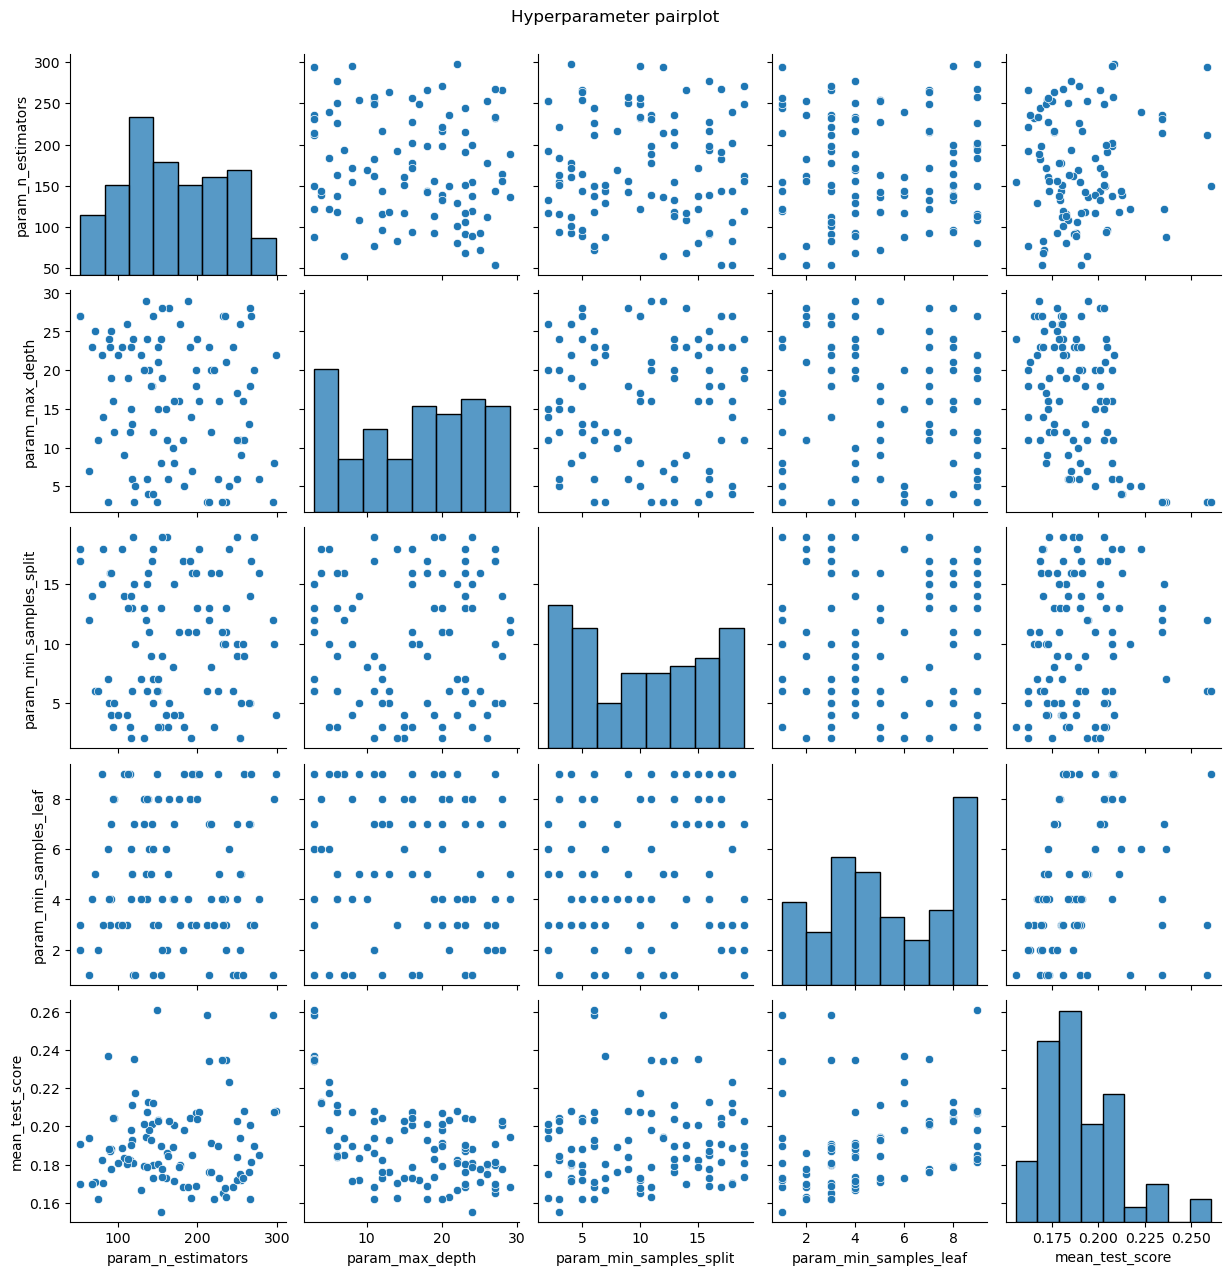

In [5]:
import seaborn as sns

cols = [
    'param_n_estimators',
    'param_max_depth',
    'param_min_samples_split',
    'param_min_samples_leaf',
    'mean_test_score'
]

sns.pairplot(cv_results[cols].dropna())
plt.suptitle("Hyperparameter pairplot", y=1.02)
plt.show()

**Step 5: Results and submission**

In [6]:
best_params = random_search.best_params_
best_score = random_search.best_score_
best_model = random_search.best_estimator_
print(best_params)
print(f"best score: {-best_score:.5f}")

{'max_depth': 24, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 154}
best score: 0.15546


In [8]:
predictions = best_model.predict(X_test_encoded)
submission = pd.DataFrame({
    'Id': pd.read_csv('test.csv')['Id'],
    'SalePrice': predictions
})
submission.to_csv('submission.csv', index=False)